In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
# plt.rcParams.update({
#     "text.usetex": True,
#     # "font.family": "serif",
#     # "font.sans-serif": "Times",
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"],
# })
# use latex
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

plt.style.use(['seaborn-v0_8-colorblind'])

In [4]:
figs_dir = "../figs"

est_dict = {
    "spambase_fedlr": "tree",
    "spambase_fedfor": "linear",
    "hugadb_fedlr": "rf",
    "hugadb_fedfor": "linear",
    "adult_fedlr": "linear",
    "adult_fedfor": "linear",
    "kdd_fedlr": "rf",
    "kdd_fedfor": "tree",
}

In [5]:
def find_cc_folders(base_dir: str):
    cc_dirs = []
    for name in os.listdir(base_dir):
        if name.startswith("CC_"):
            cc_val = float(name.replace("CC_", ""))
            full_path = os.path.join(base_dir, name)
            cc_dirs.append((cc_val, full_path))
    cc_dirs.sort(key=lambda x: x[0])
    return cc_dirs

def get_coalition_results(dataset_name: str, approach_name: str) -> pd.DataFrame:

    dataset_approach = f"{dataset_name.lower()}_{approach_name.lower()}"

    est = est_dict[dataset_approach]

    base_save_dir = f"../results/{dataset_approach}_{est}_comcost"
    

    cc_folders = find_cc_folders(base_save_dir)
    all_counts = []

    for cc_val, cc_dir in cc_folders:
        for fname in os.listdir(cc_dir):
            if fname.startswith("Nash_Counts_") and fname.endswith(".csv"):
                path = os.path.join(cc_dir, fname)
                df = pd.read_csv(path)

                if "Complete_Occurrences" in df.columns and "Static_Occurrences" not in df.columns:
                    df["Static_Occurrences"] = df["Complete_Occurrences"]

                df["comm_cost"] = cc_val
                df["source_file"] = fname
                df["n_trials"] = 100
                df["nash_rate"] = df["Static_Occurrences"] / df["n_trials"]
                df["lottery_rate"] = df["Lottery_Occurrences"] / df["n_trials"]
                all_counts.append(df)

    counts_df = pd.concat(all_counts, ignore_index=True)

    counts_df["comm_cost"] = counts_df["comm_cost"].apply(lambda x: x if x<0.1 else 0.1)

    return counts_df

In [6]:
# count_df = get_coalition_results(
#     base_save_dir="../results/spambase_fedlr_tree_comcost",
#     dataset_name="Spambase",
#     approach_name="FedLR"
# )
# count_df.head()


In [7]:
def plot_occurrences_vs_clients(dataset_name: str, approach_name: str) -> None:

    count_df = get_coalition_results(dataset_name, approach_name)
    count_df = count_df[count_df['comm_cost'].isin([0.0, 0.02, 0.05, 0.1])]

    x_values = list(range(10, 101, 10))
    cc_groups = {}
    for cc_val, subdf in count_df.groupby("comm_cost"):
        sdf = subdf.sort_values("n_clients")
        static_g = sdf[["n_clients", "Static_Occurrences"]].reset_index(drop=True)
        lot_g = sdf[["n_clients", "Lottery_Occurrences"]].reset_index(drop=True)
        static_g = static_g.set_index("n_clients").reindex(x_values).reset_index()
        lot_g = lot_g.set_index("n_clients").reindex(x_values).reset_index()
        cc_groups[cc_val] = (static_g, lot_g)



    plt.figure(figsize=(5.5, 3))
    for i, (cc_val, (static_g, lot_g)) in enumerate(cc_groups.items()):
        plt.plot(static_g["n_clients"], static_g["Static_Occurrences"], marker="s", color=f'C{i}', label=r"$\Psi^*, C$="+f"{cc_val}")

    #for i, (cc_val, (static_g, lot_g)) in enumerate(cc_groups.items()):
        plt.plot(
            lot_g["n_clients"], 
            lot_g["Lottery_Occurrences"], 
            '--', marker="^", color=f'C{i}',  mfc='none', 
            label=r"$\hat{\Psi}, C=$"+f"${cc_val}$",
        )

    plt.xlabel("$N$")
    plt.ylabel(r"Grand coalition occurrences")
    plt.xticks(x_values)
    plt.ylim(-1, 130)
    plt.xlim(10, 100)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(ncol=4, fontsize='small')
    plt.title(f'{approach_name} ({dataset_name})')

    plt.tight_layout()

    filename = f"{dataset_name.lower()}_{approach_name.lower()}.pdf"
    save_path = os.path.join(figs_dir, filename)
    plt.savefig(save_path, bbox_inches="tight")
    plt.draw()


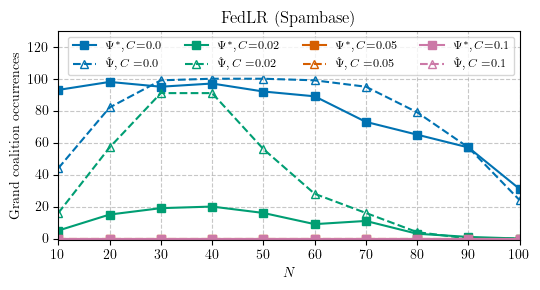

In [8]:
plot_occurrences_vs_clients(
    dataset_name="Spambase",
    approach_name="FedLR"
)

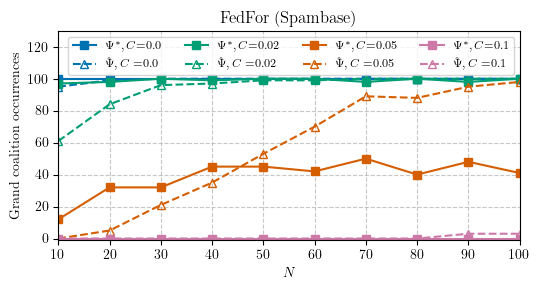

In [9]:
plot_occurrences_vs_clients(
    dataset_name="Spambase",
    approach_name="FedFor"
)

In [10]:
count_df = get_coalition_results(
    dataset_name="HuGaDB",
    approach_name="FedFor"
)

In [11]:
count_df

,comm_cost,cost_mode,n_clients,max_depth,Complete_Occurrences,Lottery_Occurrences,Static_Occurrences,source_file,n_trials,nash_rate,lottery_rate
0,0.00,fixed,50,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_50_maxiter_...,100,1.00,1.00
1,0.00,fixed,100,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_100_maxiter...,100,1.00,1.00
2,0.00,fixed,10,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_10_maxiter_...,100,1.00,1.00
3,0.00,fixed,90,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_90_maxiter_...,100,1.00,1.00
4,0.00,fixed,30,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_30_maxiter_...,100,1.00,1.00
5,0.00,fixed,60,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_60_maxiter_...,100,1.00,1.00
6,0.00,fixed,20,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_20_maxiter_...,100,1.00,1.00
7,0.00,fixed,40,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_40_maxiter_...,100,1.00,1.00
8,0.00,fixed,80,100,100,99,100,Nash_Counts_fedfor_cc_0.0_nclients_80_maxiter_...,100,1.00,0.99
9,0.00,fixed,70,100,100,100,100,Nash_Counts_fedfor_cc_0.0_nclients_70_maxiter_...,100,1.00,1.00


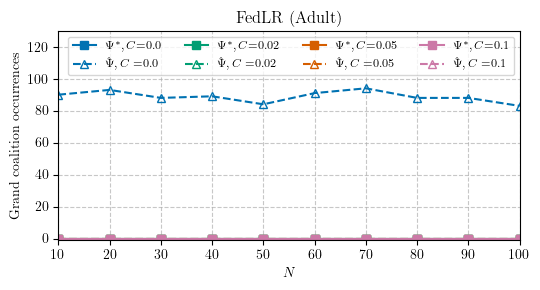

In [12]:
plot_occurrences_vs_clients(
    dataset_name="Adult",
    approach_name="FedLR"
)

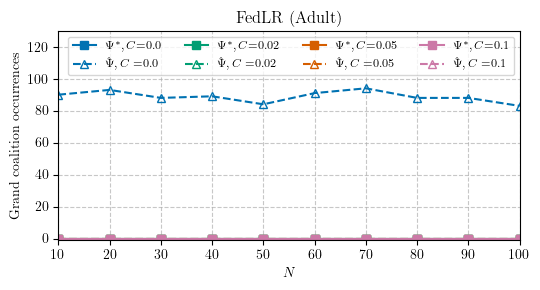

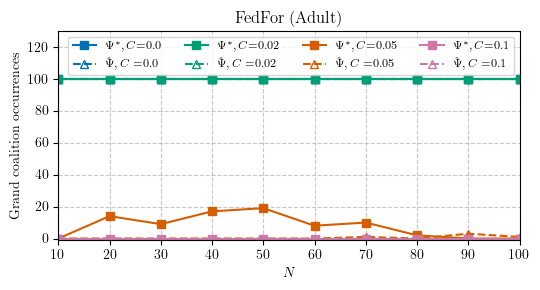

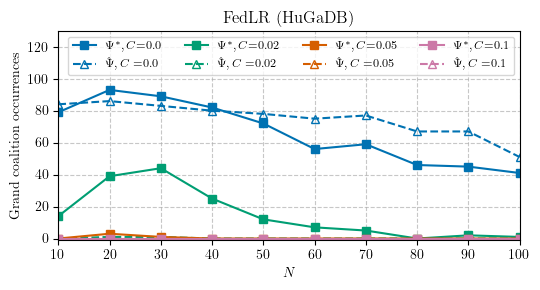

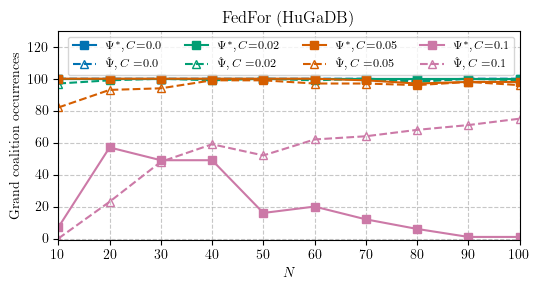

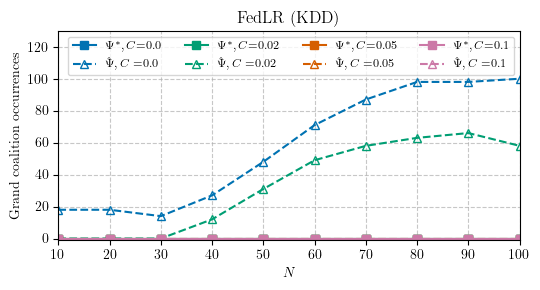

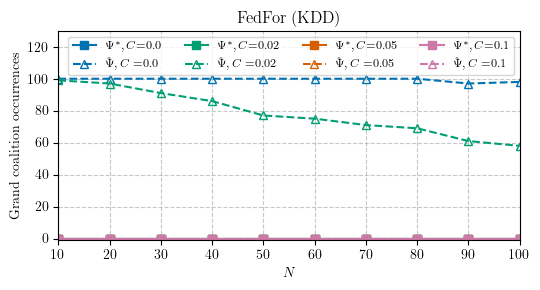

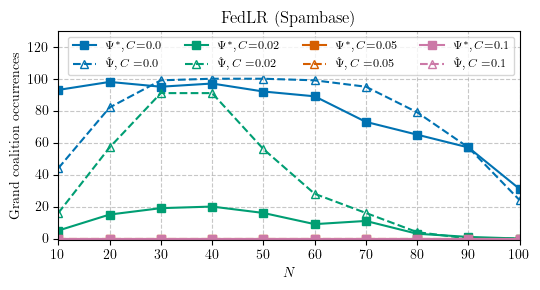

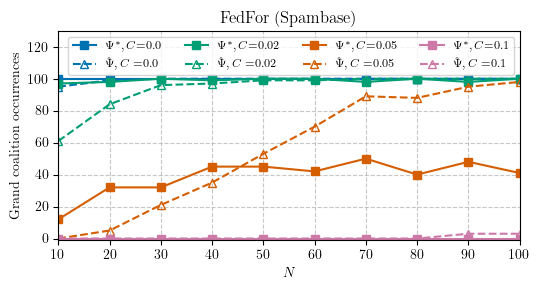

In [13]:
for dataset in ('Adult', 'HuGaDB', 'KDD', 'Spambase'):
    for approach in ('FedLR', 'FedFor'):
        plot_occurrences_vs_clients(dataset, approach)